AER 850 Machine Learning Project
Hussein Hamie 500876254
Mishran Haque 500896460

# Turbofan Engine Remaining Useful Life Prediction
**DATASET:** NASA Turbofan Jet Engine Data Set
**By:** Hussein Hamie and Mishran Haque

In [44]:
%reset

# Introduction


![Image of ](https://i.postimg.cc/ZqdZ56mW/turbo-jet-engine-diagram.jpg)

Data sets consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.

The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. The objective of the competition is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. Also provided a vector of true Remaining Useful Life (RUL) values for the test data.

The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:
1) unit number
2) time, in cycles
3) operational setting 1
4) operational setting 2
5) operational setting 3
6) sensor measurement 1
7) sensor measurement 2
...
26) sensor measurement 26

Data Set: FD001
Train trjectories: 100
Test trajectories: 100
Conditions: ONE (Sea Level)
Fault Modes: ONE (HPC Degradation)

Data Set: FD002
Train trjectories: 260
Test trajectories: 259
Conditions: SIX
Fault Modes: ONE (HPC Degradation)

Data Set: FD003
Train trjectories: 100
Test trajectories: 100
Conditions: ONE (Sea Level)
Fault Modes: TWO (HPC Degradation, Fan Degradation)

Data Set: FD004
Train trjectories: 248
Test trajectories: 249
Conditions: SIX
Fault Modes: TWO (HPC Degradation, Fan Degradation)

Reference: A. Saxena, K. Goebel, D. Simon, and N. Eklund, ‘Damage Propagation Modeling for Aircraft Engine Run-to-Failure Simulation’, in the Proceedings of the 1st International Conference on Prognostics and Health Management (PHM08), Denver CO, Oct 2008.

In [66]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from pylab import rcParams
import math
import xgboost
import time
from tqdm import tqdm
import keras.models
import keras.layers
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import warnings
warnings.simplefilter('ignore')

In [46]:
data_train = pd.read_csv("/mnt/e/Coding/MachineLearningCourse/Project/CMaps/train_FD001.txt",sep=" ",header=None)
data_test = pd.read_csv("/mnt/e/Coding/MachineLearningCourse/Project/CMaps/test_FD001.txt",sep=" ",header=None)
data_RUL = pd.read_csv("/mnt/e/Coding/MachineLearningCourse/Project/CMaps/RUL_FD001.txt",sep=" ",header=None)

train_copy = data_train
test_copy = data_test

# Exploratory Data Analysis

In [47]:
# Remove the  NaN Columns
data_train.drop(columns=[26,27],inplace=True)
data_test.drop(columns=[26,27],inplace=True)
data_RUL.drop(columns=[1],inplace=True)

In [77]:
column_names= ['unit_ID','cycles','setting_1','setting_2','setting_3',' Total Temperature at fan inlet','Total Temperature at LPC outlet','Total Temperature HPC outlet','Total Temperature LPT outlet','Pressure at fan Inlet','Total pressure in bypass-duct','Total pressure at HPC outlet','Physcial fan speed',
           'Physical Core speed','Engine Pressure Ratio (P50/P2)','Static pressure at HPC outlet','Ratio of fuel flow to Ps30','Corrected fan speed','Corrected core speed','Bypass Ratio','Burner fuel-air ratio','Bleed Enthalpy','Demanded fan speed','Demanded corrected fan speed','HPT coolant bleed','LPT coolant bleed' ]
data_train.columns = column_names
data_test.columns=column_names
data_train.describe()

unit_ID        cycles     setting_1     setting_2  setting_3  \
count  20631.000000  20631.000000  20631.000000  20631.000000    20631.0   
mean      51.506568    108.807862     -0.000009      0.000002      100.0   
std       29.227633     68.880990      0.002187      0.000293        0.0   
min        1.000000      1.000000     -0.008700     -0.000600      100.0   
25%       26.000000     52.000000     -0.001500     -0.000200      100.0   
50%       52.000000    104.000000      0.000000      0.000000      100.0   
75%       77.000000    156.000000      0.001500      0.000300      100.0   
max      100.000000    362.000000      0.008700      0.000600      100.0   

        Total Temperature at fan inlet  Total Temperature at LPC outlet  \
count                     2.063100e+04                     20631.000000   
mean                      5.186700e+02                       642.680934   
std                       6.537152e-11                         0.500053   
min                       5.186700e+02                       641.210000   
25%                       5.186700e+02                       642.325000   
50%                       5.186700e+02                       642.640000   
75%                       5.186700e+02                       643.000000   
max                       5.186700e+02                       644.530000   

       Total Temperature HPC outlet  Total Temperature LPT outlet  \
count                  20631.000000                  20631.000000   
mean                    1590.523119                   1408.933782   
std                        6.131150                      9.000605   
min                     1571.040000                   1382.250000   
25%                     1586.260000                   1402.360000   
50%                     1590.100000                   1408.040000   
75%                     1594.380000                   1414.555000   
max                     1616.910000                   1441.490000   

       Pressure at fan Inlet  ...  Ratio of fuel flow to Ps30  \
count           2.063100e+04  ...                20631.000000   
mean            1.462000e+01  ...                  521.413470   
std             3.394700e-12  ...                    0.737553   
min             1.462000e+01  ...                  518.690000   
25%             1.462000e+01  ...                  520.960000   
50%             1.462000e+01  ...                  521.480000   
75%             1.462000e+01  ...                  521.950000   
max             1.462000e+01  ...                  523.380000   

       Corrected fan speed  Corrected core speed  Bypass Ratio  \
count         20631.000000          20631.000000  20631.000000   
mean           2388.096152           8143.752722      8.442146   
std               0.071919             19.076176      0.037505   
min            2387.880000           8099.940000      8.324900   
25%            2388.040000           8133.245000      8.414900   
50%            2388.090000           8140.540000      8.438900   
75%            2388.140000           8148.310000      8.465600   
max            2388.560000           8293.720000      8.584800   

       Burner fuel-air ratio  Bleed Enthalpy  Demanded fan speed  \
count           2.063100e+04    20631.000000             20631.0   
mean            3.000000e-02      393.210654              2388.0   
std             1.556432e-14        1.548763                 0.0   
min             3.000000e-02      388.000000              2388.0   
25%             3.000000e-02      392.000000              2388.0   
50%             3.000000e-02      393.000000              2388.0   
75%             3.000000e-02      394.000000              2388.0   
max             3.000000e-02      400.000000              2388.0   

       Demanded corrected fan speed  HPT coolant bleed  LPT coolant bleed  
count                       20631.0       20631.000000       20631.000000  
mean                          100.0          38.816271          23.289705  
std    

In [78]:
data_test

unit_ID  cycles  setting_1  setting_2  setting_3  \
0            1       1     0.0023     0.0003      100.0   
1            1       2    -0.0027    -0.0003      100.0   
2            1       3     0.0003     0.0001      100.0   
3            1       4     0.0042     0.0000      100.0   
4            1       5     0.0014     0.0000      100.0   
...        ...     ...        ...        ...        ...   
13091      100     194     0.0049     0.0000      100.0   
13092      100     195    -0.0011    -0.0001      100.0   
13093      100     196    -0.0006    -0.0003      100.0   
13094      100     197    -0.0038     0.0001      100.0   
13095      100     198     0.0013     0.0003      100.0   

        Total Temperature at fan inlet  Total Temperature at LPC outlet  \
0                               518.67                           643.02   
1                               518.67                           641.71   
2                               518.67                           642.46   
3                               518.67                           642.44   
4                               518.67                           642.51   
...                                ...                              ...   
13091                           518.67                           643.24   
13092                           518.67                           643.22   
13093                           518.67                           643.44   
13094                           518.67                           643.26   
13095                           518.67                           642.95   

       Total Temperature HPC outlet  Total Temperature LPT outlet  \
0                           1585.29                       1398.21   
1                           1588.45                       1395.42   
2                           1586.94                       1401.34   
3                           1584.12                       1406.42   
4                           1587.19                       1401.92   
...                             ...                           ...   
13091                       1599.45                       1415.79   
13092                       1595.69                       1422.05   
13093                       1593.15                       1406.82   
13094                       1594.99                       1419.36   
13095                       1601.62                       1424.99   

       Pressure at fan Inlet  ...  Ratio of fuel flow to Ps30  \
0                      14.62  ...                      521.72   
1                      14.62  ...                      522.16   
2                      14.62  ...                      521.97   
3                      14.62  ...                      521.38   
4                      14.62  ...                      522.15   
...                      ...  ...                         ...   
13091                  14.62  ...                      520.69   
13092                  14.62  ...                      521.05   
13093                  14.62  ...                      521.18   
13094                  14.62  ...                      521.33   
13095                  14.62  ...                      521.07   

       Corrected fan speed  Corrected core speed  Bypass Ratio  \
0                  2388.03               8125.55        8.4052   
1                  2388.06               8139.62        8.3803   
2                  2388.03               8130.10        8.4441   
3                  2388.05               8132.90        8.3917   
4                  2388.03               8129.54        8.4031   
...                    ...                   ...           ...   
13091              2388.00               8213.28        8.4715   
13092              2388.09               8210.85        8.4512   
13093              2388.04               8217.24        8.4569   
13094              2388.08               8220.48        8.4711   
13095              2388.05               8214.64        8.490

In [49]:
data_train

unit_ID  cycles  setting_1  setting_2  setting_3  \
0            1       1    -0.0007    -0.0004      100.0   
1            1       2     0.0019    -0.0003      100.0   
2            1       3    -0.0043     0.0003      100.0   
3            1       4     0.0007     0.0000      100.0   
4            1       5    -0.0019    -0.0002      100.0   
...        ...     ...        ...        ...        ...   
20626      100     196    -0.0004    -0.0003      100.0   
20627      100     197    -0.0016    -0.0005      100.0   
20628      100     198     0.0004     0.0000      100.0   
20629      100     199    -0.0011     0.0003      100.0   
20630      100     200    -0.0032    -0.0005      100.0   

        Total Temperature at fan inlet  Total Temperature at LPC outlet  \
0                               518.67                           641.82   
1                               518.67                           642.15   
2                               518.67                           642.35   
3                               518.67                           642.35   
4                               518.67                           642.37   
...                                ...                              ...   
20626                           518.67                           643.49   
20627                           518.67                           643.54   
20628                           518.67                           643.42   
20629                           518.67                           643.23   
20630                           518.67                           643.85   

       Total Temperature HPC outlet  Total Temperature LPT outlet  \
0                           1589.70                       1400.60   
1                           1591.82                       1403.14   
2                           1587.99                       1404.20   
3                           1582.79                       1401.87   
4                           1582.85                       1406.22   
...                             ...                           ...   
20626                       1597.98                       1428.63   
20627                       1604.50                       1433.58   
20628                       1602.46                       1428.18   
20629                       1605.26                       1426.53   
20630                       1600.38                       1432.14   

       Pressure at fan Inlet  ...  Ratio of fuel flow to Ps30  \
0                      14.62  ...                      521.66   
1                      14.62  ...                      522.28   
2                      14.62  ...                      522.42   
3                      14.62  ...                      522.86   
4                      14.62  ...                      522.19   
...                      ...  ...                         ...   
20626                  14.62  ...                      519.49   
20627                  14.62  ...                      519.68   
20628                  14.62  ...                      520.01   
20629                  14.62  ...                      519.67   
20630                  14.62  ...                      519.30   

       Corrected fan speed  Corrected core speed  Bypass Ratio  \
0                  2388.02               8138.62        8.4195   
1                  2388.07               8131.49        8.4318   
2                  2388.03               8133.23        8.4178   
3                  2388.08               8133.83        8.3682   
4                  2388.04               8133.80        8.4294   
...                    ...                   ...           ...   
20626              2388.26               8137.60        8.4956   
20627              2388.22               8136.50        8.5139   
20628              2388.24               8141.05        8.5646   
20629              2388.23               8139.29        8.5389   
20630              2388.26               8137.33        8.503

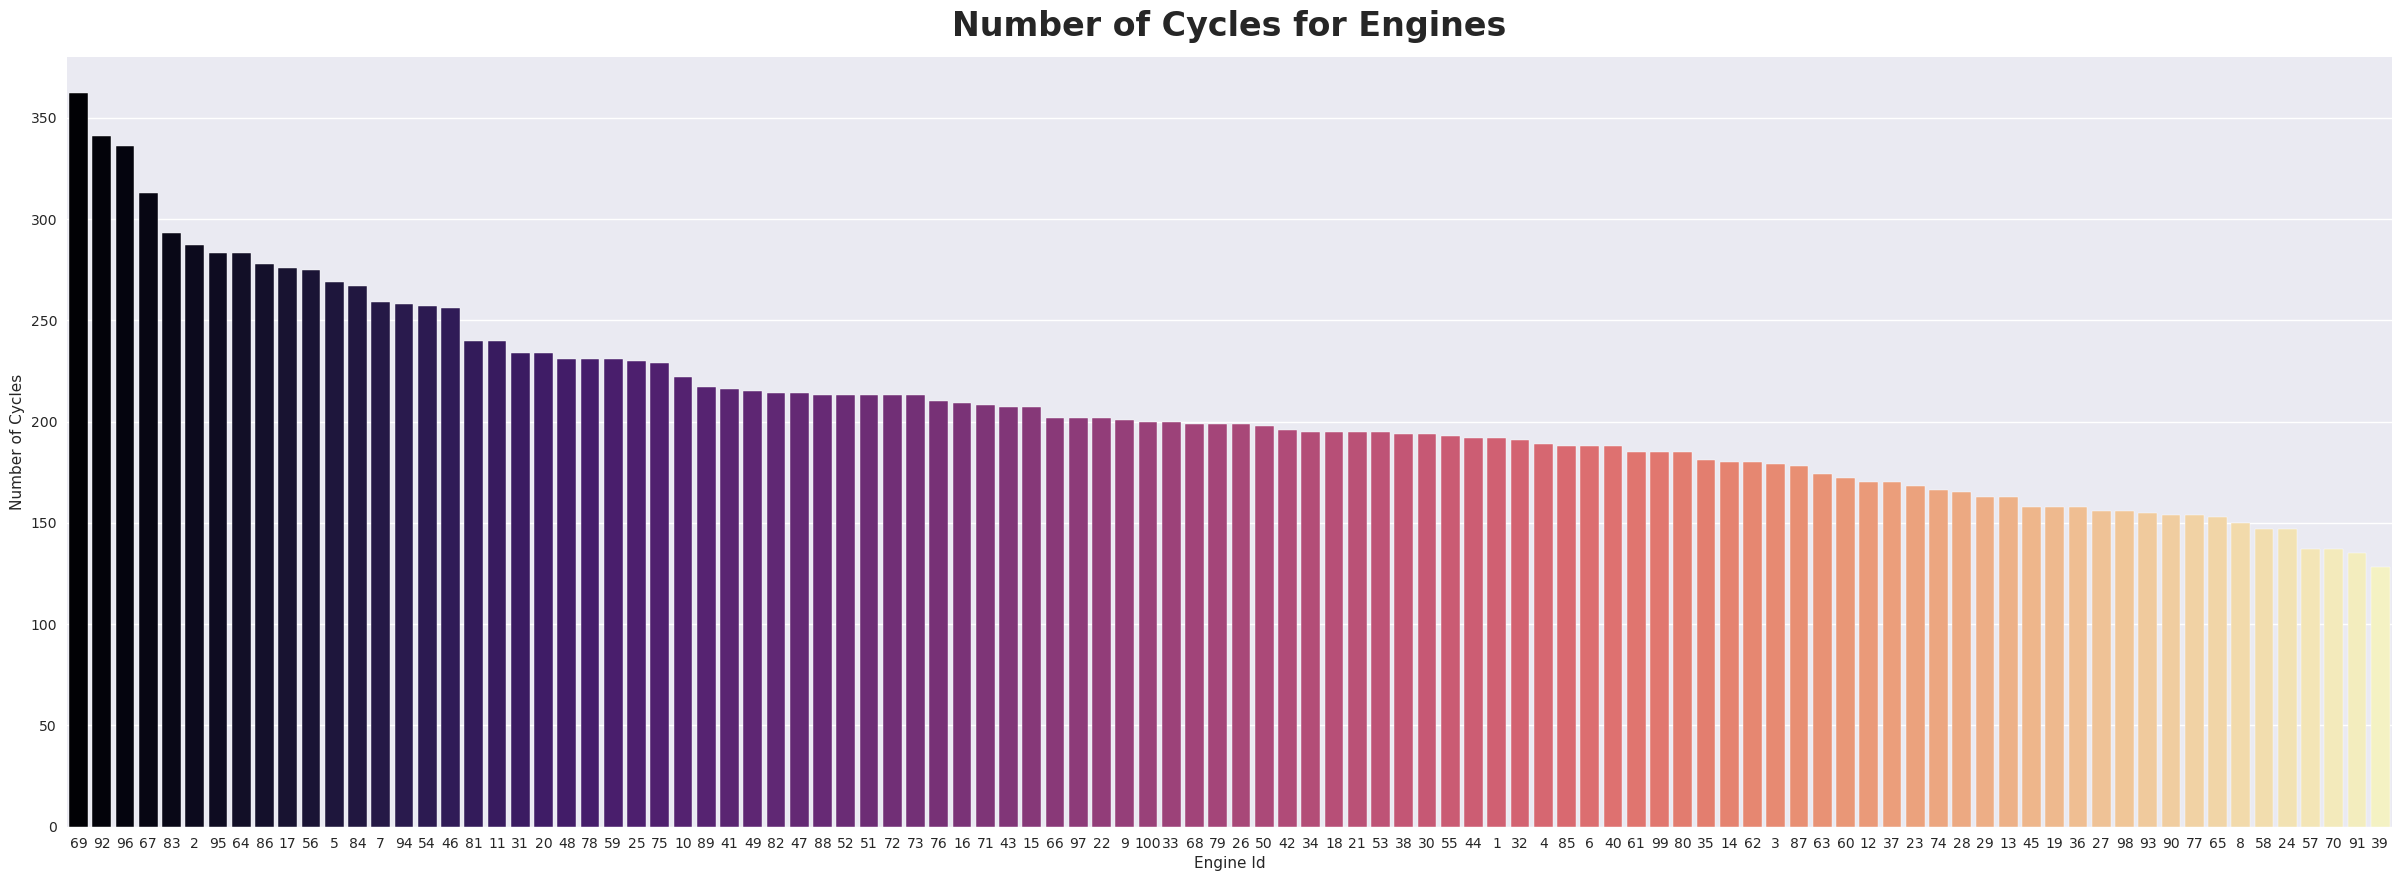

In [50]:
cnt_train = data_train[["unit_ID", "cycles"]].groupby("unit_ID").max().sort_values(by="cycles", ascending=False)
cnt_ind = [str(i) for i in cnt_train.index.to_list()]
cnt_val = list(cnt_train.cycles.values)

plt.style.use("seaborn")
plt.figure(figsize=(30, 10))
sns.barplot(x=list(cnt_ind), y=list(cnt_val), palette='magma')
plt.ylabel('Number of Cycles')
plt.xlabel('Engine Id')
plt.title('Number of Cycles for Engines', fontweight='bold', fontsize=24, pad=15)

plt.show()

Mean number of cycles after which jet engine fails is 206


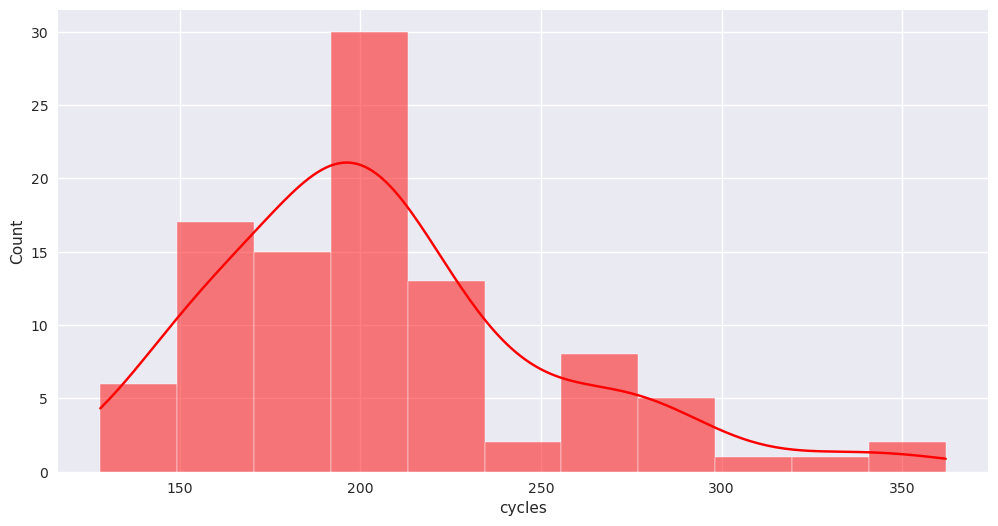

In [51]:
plt.subplots(figsize=(12, 6))
sns.histplot(cnt_train["cycles"], kde = True, color='red');
print("Mean number of cycles after which jet engine fails is "+ str(math.floor(cnt_train["cycles"].mean())))

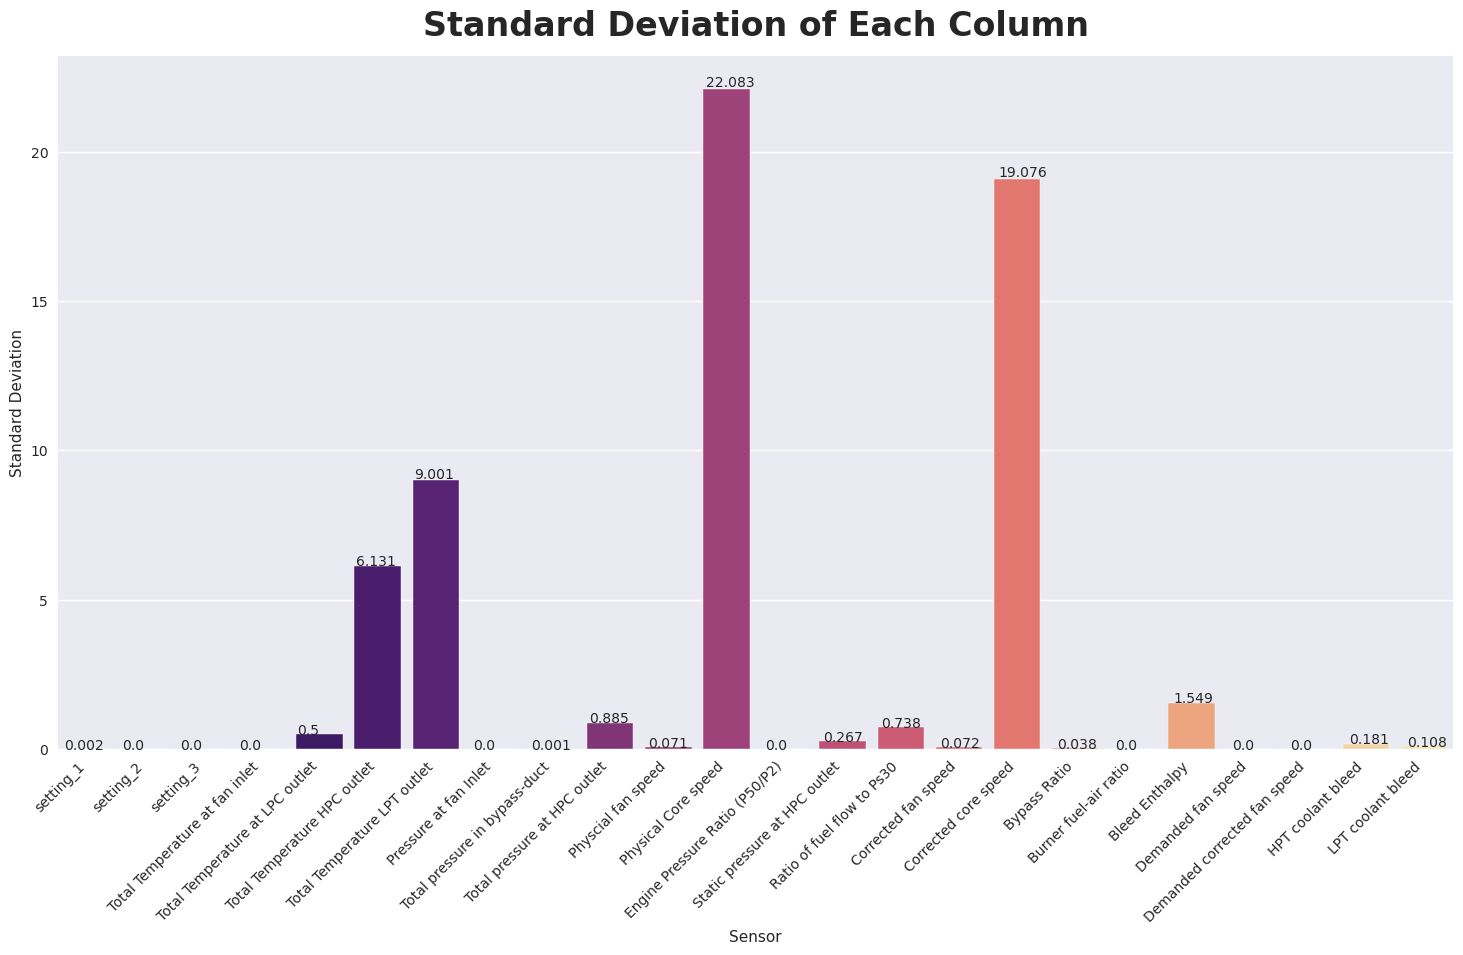

In [52]:
plt.figure(figsize=(18, 9))
subset_stats = data_train.agg(['mean', 'std']).T[2:]
ax = sns.barplot(x=subset_stats.index, y="std", data=subset_stats, palette='magma')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_xlabel("Sensor")
ax.set_ylabel("Standard Deviation")
ax.set_title("Standard Deviation of Each Column", fontweight='bold', fontsize=24, pad=15)

for p in ax.patches:
    ax.annotate(str(round(p.get_height(),3)), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()

From this plot we can see which features we can drop as the standard deviation is 0.

In [56]:
train = data_train
train = train.drop(columns=['setting_1','setting_2','setting_3',' Total Temperature at fan inlet','Pressure at fan Inlet','Engine Pressure Ratio (P50/P2)','Burner fuel-air ratio','Demanded fan speed','Demanded corrected fan speed'])

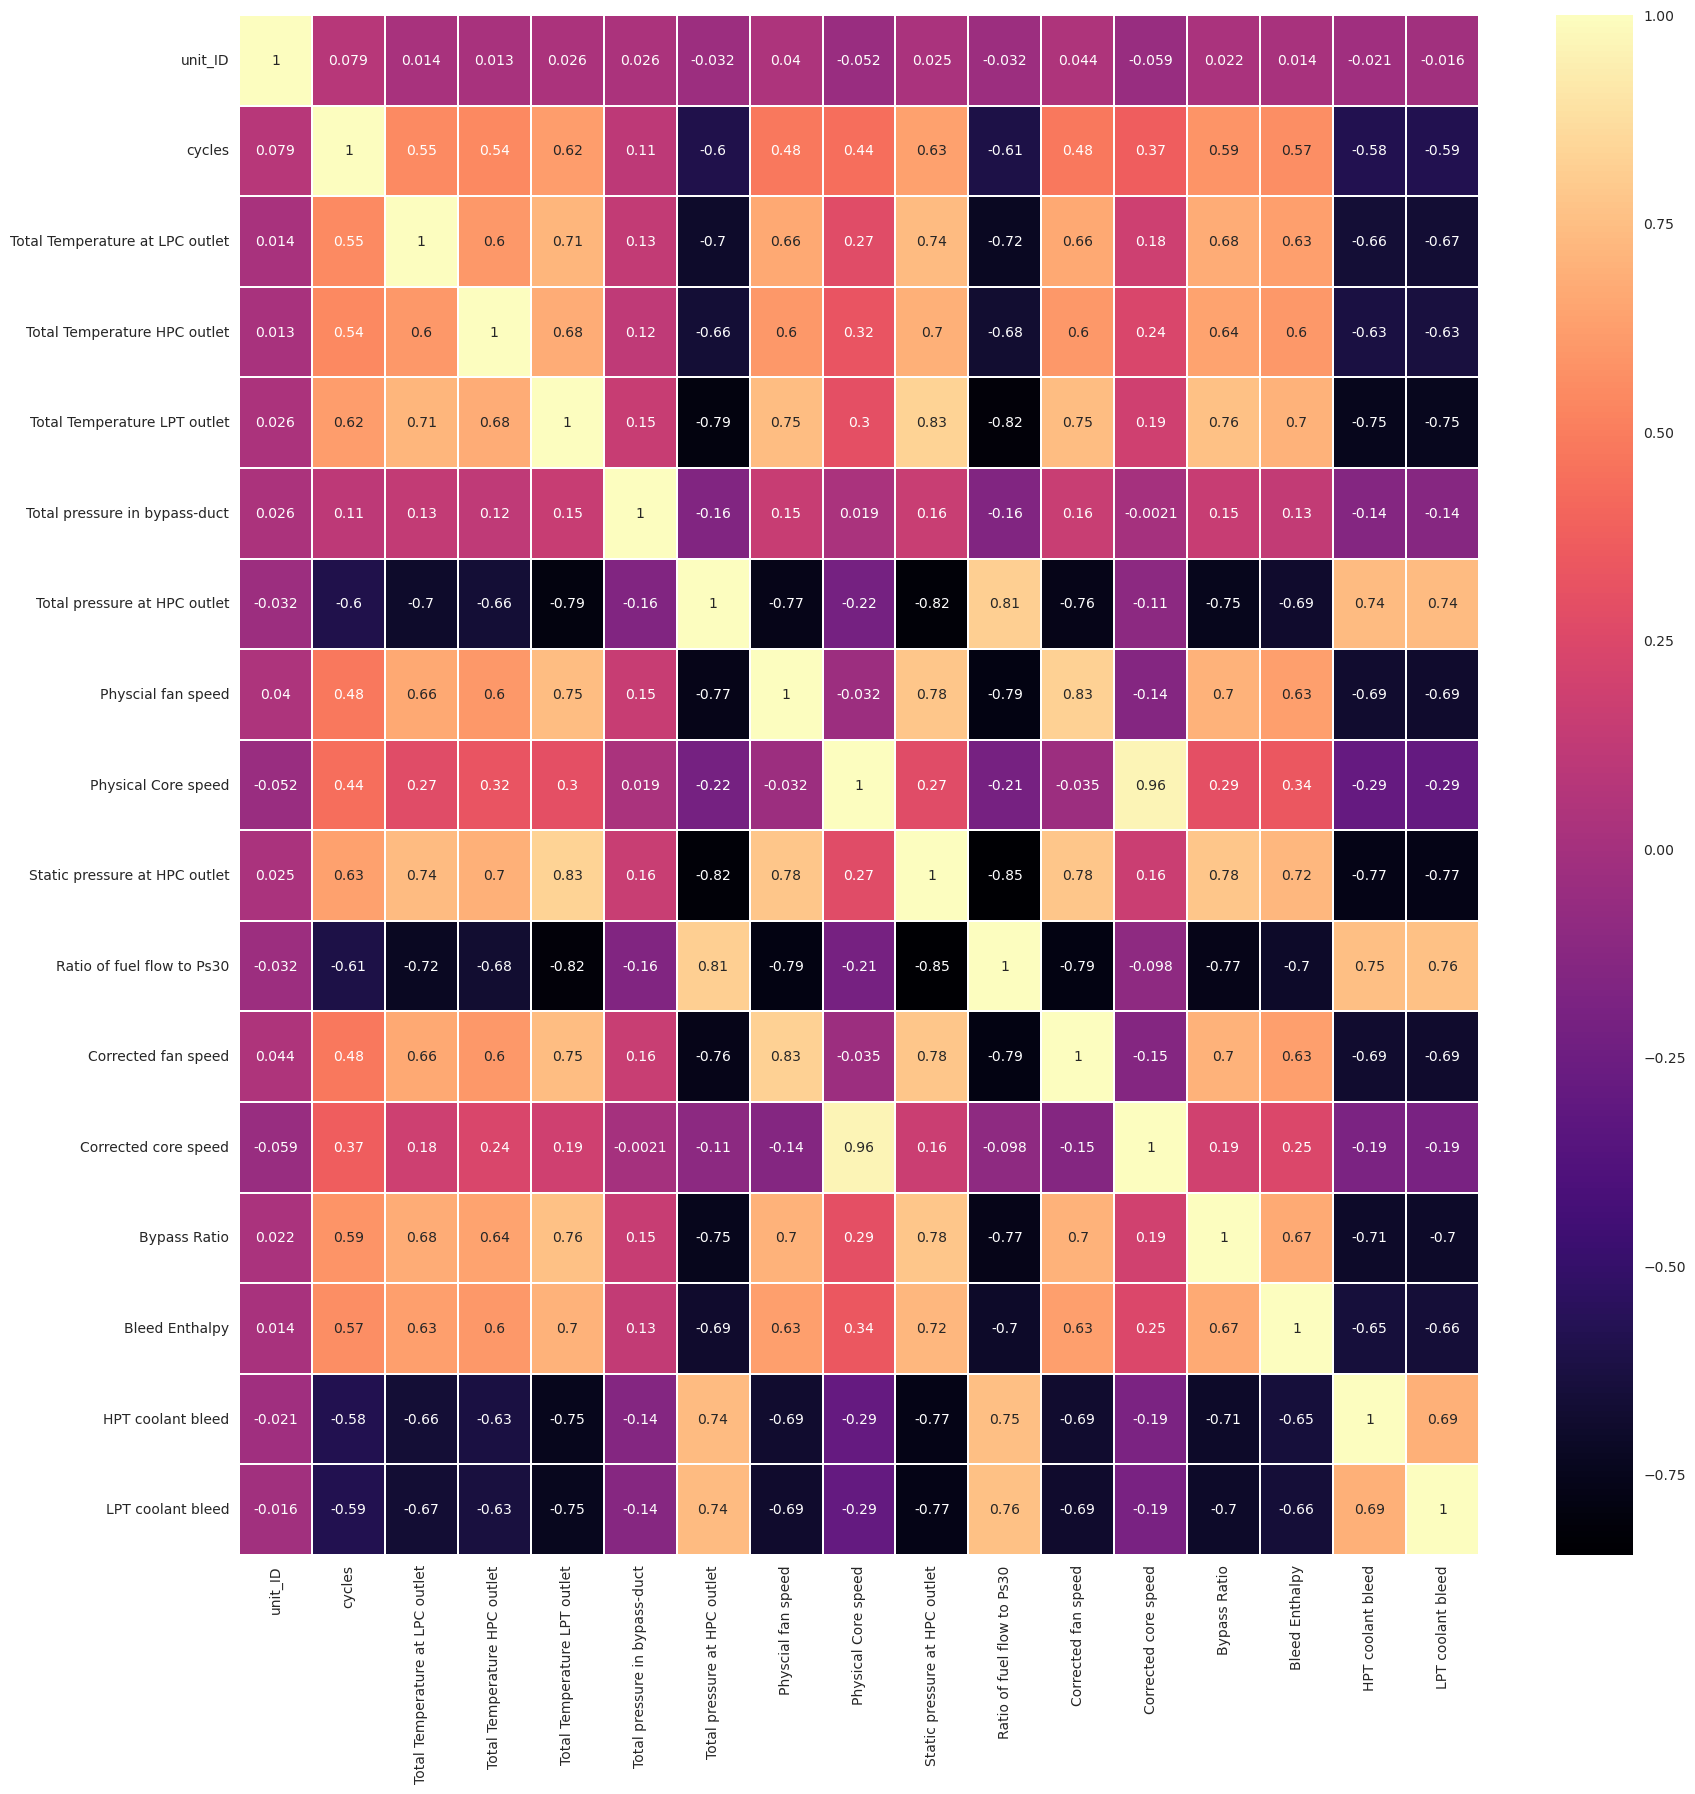

In [57]:
sns.heatmap(train.corr(),annot=True,cmap='magma',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(20,20)
plt.show()

# **Data Preperation**

**Establishing Remaining Useful Life (RUL) in Cycles**

In [83]:
# Define a function to calculate the remaining useful life (RUL)
def add_rul(g):
    # Calculate the RUL as the difference between the maximum cycle value and the cycle value for each row
    g['RUL'] = max(g['cycles']) - g['cycles']
    return g

# Apply the add_rul function to the training data grouped by the unit ID
train = train.groupby('unit_ID').apply(add_rul)

In [84]:
scaler = MinMaxScaler()

In [87]:
ntrain=train.copy()
ntrain

unit_ID  cycles  Total Temperature at LPC outlet  \
0            1       1                           641.82   
1            1       2                           642.15   
2            1       3                           642.35   
3            1       4                           642.35   
4            1       5                           642.37   
...        ...     ...                              ...   
20626      100     196                           643.49   
20627      100     197                           643.54   
20628      100     198                           643.42   
20629      100     199                           643.23   
20630      100     200                           643.85   

       Total Temperature HPC outlet  Total Temperature LPT outlet  \
0                           1589.70                       1400.60   
1                           1591.82                       1403.14   
2                           1587.99                       1404.20   
3                           1582.79                       1401.87   
4                           1582.85                       1406.22   
...                             ...                           ...   
20626                       1597.98                       1428.63   
20627                       1604.50                       1433.58   
20628                       1602.46                       1428.18   
20629                       1605.26                       1426.53   
20630                       1600.38                       1432.14   

       Total pressure in bypass-duct  Total pressure at HPC outlet  \
0                              21.61                        554.36   
1                              21.61                        553.75   
2                              21.61                        554.26   
3                              21.61                        554.45   
4                              21.61                        554.00   
...                              ...                           ...   
20626                          21.61                        551.43   
20627                          21.61                        550.86   
20628                          21.61                        550.94   
20629                          21.61                        550.68   
20630                          21.61                        550.79   

       Physcial fan speed  Physical Core speed  Static pressure at HPC outlet  \
0                 2388.06              9046.19                          47.47   
1                 2388.04              9044.07                          47.49   
2                 2388.08              9052.94                          47.27   
3                 2388.11              9049.48                          47.13   
4                 2388.06              9055.15                          47.28   
...                   ...                  ...                            ...   
20626             2388.19              9065.52                          48.07   
20627             2388.23              9065.11                          48.04   
20628             2388.24              9065.90                          48.09   
20629             2388.25              9073.72                          48.39   
20630             2388.26              9061.48                          48.20   

       Ratio of fuel flow to Ps30  Corrected fan speed  Corrected core speed  \
0                          521.66              2388.02               8138.62   
1                          522.28              2388.07               8131.49   
2                          522.42              2388.03               8133.23   
3                          522.86              2388.08               8133.83   
4                          522.19              2388.04               8133.80   
...                           ...                  ...                   ...   
20626                      519.49              2388.26               8137.60   
20627          

In [88]:
ntrain.iloc[:,2:17] = scaler.fit_transform(ntrain.iloc[:,2:17])
ntrain

unit_ID  cycles  Total Temperature at LPC outlet  \
0            1       1                         0.183735   
1            1       2                         0.283133   
2            1       3                         0.343373   
3            1       4                         0.343373   
4            1       5                         0.349398   
...        ...     ...                              ...   
20626      100     196                         0.686747   
20627      100     197                         0.701807   
20628      100     198                         0.665663   
20629      100     199                         0.608434   
20630      100     200                         0.795181   

       Total Temperature HPC outlet  Total Temperature LPT outlet  \
0                          0.406802                      0.309757   
1                          0.453019                      0.352633   
2                          0.369523                      0.370527   
3                          0.256159                      0.331195   
4                          0.257467                      0.404625   
...                             ...                           ...   
20626                      0.587312                      0.782917   
20627                      0.729453                      0.866475   
20628                      0.684979                      0.775321   
20629                      0.746021                      0.747468   
20630                      0.639634                      0.842167   

       Total pressure in bypass-duct  Total pressure at HPC outlet  \
0                                1.0                      0.726248   
1                                1.0                      0.628019   
2                                1.0                      0.710145   
3                                1.0                      0.740741   
4                                1.0                      0.668277   
...                              ...                           ...   
20626                            1.0                      0.254428   
20627                            1.0                      0.162641   
20628                            1.0                      0.175523   
20629                            1.0                      0.133655   
20630                            1.0                      0.151369   

       Physcial fan speed  Physical Core speed  Static pressure at HPC outlet  \
0                0.242424             0.109755                       0.369048   
1                0.212121             0.100242                       0.380952   
2                0.272727             0.140043                       0.250000   
3                0.318182             0.124518                       0.166667   
4                0.242424             0.149960                       0.255952   
...                   ...                  ...                            ...   
20626            0.439394             0.196491                       0.726190   
20627            0.500000             0.194651                       0.708333   
20628            0.515152             0.198196                       0.738095   
20629            0.530303             0.233285                       0.916667   
20630            0.545455             0.178363                       0.803571   

       Ratio of fuel flow to Ps30  Corrected fan speed  Corrected core speed  \
0                        0.633262             0.205882              0.199608   
1                        0.765458             0.279412              0.162813   
2                        0.795309             0.220588              0.171793   
3                        0.889126             0.294118              0.174889   
4                        0.746269             0.235294              0.174734   
...                           ...                  ...                   ...   
20626                    0.170576             0.558824              0.194344   
20627          

In [89]:
ntest=data_test.copy()
ntest = ntest.drop(columns=['setting_1','setting_2','setting_3',' Total Temperature at fan inlet','Pressure at fan Inlet','Engine Pressure Ratio (P50/P2)','Burner fuel-air ratio','Demanded fan speed','Demanded corrected fan speed'])
ntest

unit_ID  cycles  Total Temperature at LPC outlet  \
0            1       1                           643.02   
1            1       2                           641.71   
2            1       3                           642.46   
3            1       4                           642.44   
4            1       5                           642.51   
...        ...     ...                              ...   
13091      100     194                           643.24   
13092      100     195                           643.22   
13093      100     196                           643.44   
13094      100     197                           643.26   
13095      100     198                           642.95   

       Total Temperature HPC outlet  Total Temperature LPT outlet  \
0                           1585.29                       1398.21   
1                           1588.45                       1395.42   
2                           1586.94                       1401.34   
3                           1584.12                       1406.42   
4                           1587.19                       1401.92   
...                             ...                           ...   
13091                       1599.45                       1415.79   
13092                       1595.69                       1422.05   
13093                       1593.15                       1406.82   
13094                       1594.99                       1419.36   
13095                       1601.62                       1424.99   

       Total pressure in bypass-duct  Total pressure at HPC outlet  \
0                              21.61                        553.90   
1                              21.61                        554.85   
2                              21.61                        554.11   
3                              21.61                        554.07   
4                              21.61                        554.16   
...                              ...                           ...   
13091                          21.61                        553.41   
13092                          21.61                        553.22   
13093                          21.61                        553.04   
13094                          21.61                        553.37   
13095                          21.61                        552.48   

       Physcial fan speed  Physical Core speed  Static pressure at HPC outlet  \
0                 2388.04              9050.17                          47.20   
1                 2388.01              9054.42                          47.50   
2                 2388.05              9056.96                          47.50   
3                 2388.03              9045.29                          47.28   
4                 2388.01              9044.55                          47.31   
...                   ...                  ...                            ...   
13091             2388.02              9142.37                          47.69   
13092             2388.05              9140.68                          47.60   
13093             2388.11              9146.81                          47.57   
13094             2388.07              9148.85                          47.61   
13095             2388.06              9155.03                          47.80   

       Ratio of fuel flow to Ps30  Corrected fan speed  Corrected core speed  \
0                          521.72              2388.03               8125.55   
1                          522.16              2388.06               8139.62   
2                          521.97              2388.03               8130.10   
3                          521.38              2388.05               8132.90   
4                          522.15              2388.03               8129.54   
...                           ...                  ...                   ...   
13091                      520.69              2388.00               8213.28   
13092          

In [90]:
ntest.iloc[:,2:17] = scaler.transform(ntest.iloc[:,2:17])
ntest

unit_ID  cycles  Total Temperature at LPC outlet  \
0            1       1                         0.545181   
1            1       2                         0.150602   
2            1       3                         0.376506   
3            1       4                         0.370482   
4            1       5                         0.391566   
...        ...     ...                              ...   
13091      100     194                         0.611446   
13092      100     195                         0.605422   
13093      100     196                         0.671687   
13094      100     197                         0.617470   
13095      100     198                         0.524096   

       Total Temperature HPC outlet  Total Temperature LPT outlet  \
0                          0.310661                      0.269413   
1                          0.379551                      0.222316   
2                          0.346632                      0.322248   
3                          0.285154                      0.408001   
4                          0.352082                      0.332039   
...                             ...                           ...   
13091                      0.619359                      0.566172   
13092                      0.537388                      0.671843   
13093                      0.482014                      0.414754   
13094                      0.522128                      0.626435   
13095                      0.666667                      0.721472   

       Total pressure in bypass-duct  Total pressure at HPC outlet  \
0                                1.0                      0.652174   
1                                1.0                      0.805153   
2                                1.0                      0.685990   
3                                1.0                      0.679549   
4                                1.0                      0.694042   
...                              ...                           ...   
13091                            1.0                      0.573269   
13092                            1.0                      0.542673   
13093                            1.0                      0.513688   
13094                            1.0                      0.566828   
13095                            1.0                      0.423510   

       Physcial fan speed  Physical Core speed  Static pressure at HPC outlet  \
0                0.212121             0.127614                       0.208333   
1                0.166667             0.146684                       0.386905   
2                0.227273             0.158081                       0.386905   
3                0.196970             0.105717                       0.255952   
4                0.166667             0.102396                       0.273810   
...                   ...                  ...                            ...   
13091            0.181818             0.541326                       0.500000   
13092            0.227273             0.533743                       0.446429   
13093            0.318182             0.561249                       0.428571   
13094            0.257576             0.570403                       0.452381   
13095            0.242424             0.598133                       0.565476   

       Ratio of fuel flow to Ps30  Corrected fan speed  Corrected core speed  \
0                        0.646055             0.220588              0.132160   
1                        0.739872             0.264706              0.204768   
2                        0.699360             0.220588              0.155640   
3                        0.573561             0.250000              0.170090   
4                        0.737740             0.220588              0.152751   
...                           ...                  ...                   ...   
13091                    0.426439             0.176471              0.584890   
13092          

**Visualizing the Scaled Data**

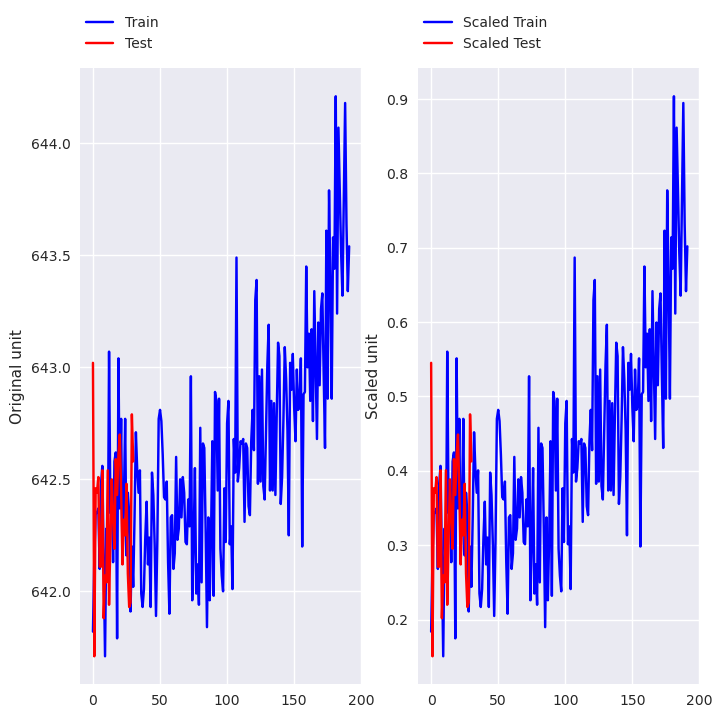

In [107]:
fig = plt.figure(figsize = (8, 8))
fig.add_subplot(1,2,1)
plt.plot(train[train.unit_ID==1]['Total Temperature at LPC outlet'], color="blue")
plt.plot(data_test[data_test.unit_ID==1]['Total Temperature at LPC outlet'], color="red")
plt.legend(["Train","Test"], bbox_to_anchor=(0., 1.02, 1., .102), loc=3, mode="expand", borderaxespad=0)
plt.ylabel("Original unit")
fig.add_subplot(1,2,2)
plt.plot(ntrain[ntrain.unit_ID==1]['Total Temperature at LPC outlet'], color='blue')
plt.plot(ntest[ntest.unit_ID==1]['Total Temperature at LPC outlet'], color="red")
plt.legend(["Scaled Train",'Scaled Test'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3, mode="expand", borderaxespad=0)
plt.ylabel("Scaled unit")
plt.show()

In [110]:
cyclestrain = train.groupby('unit_ID', as_index=False)['cycles'].max()

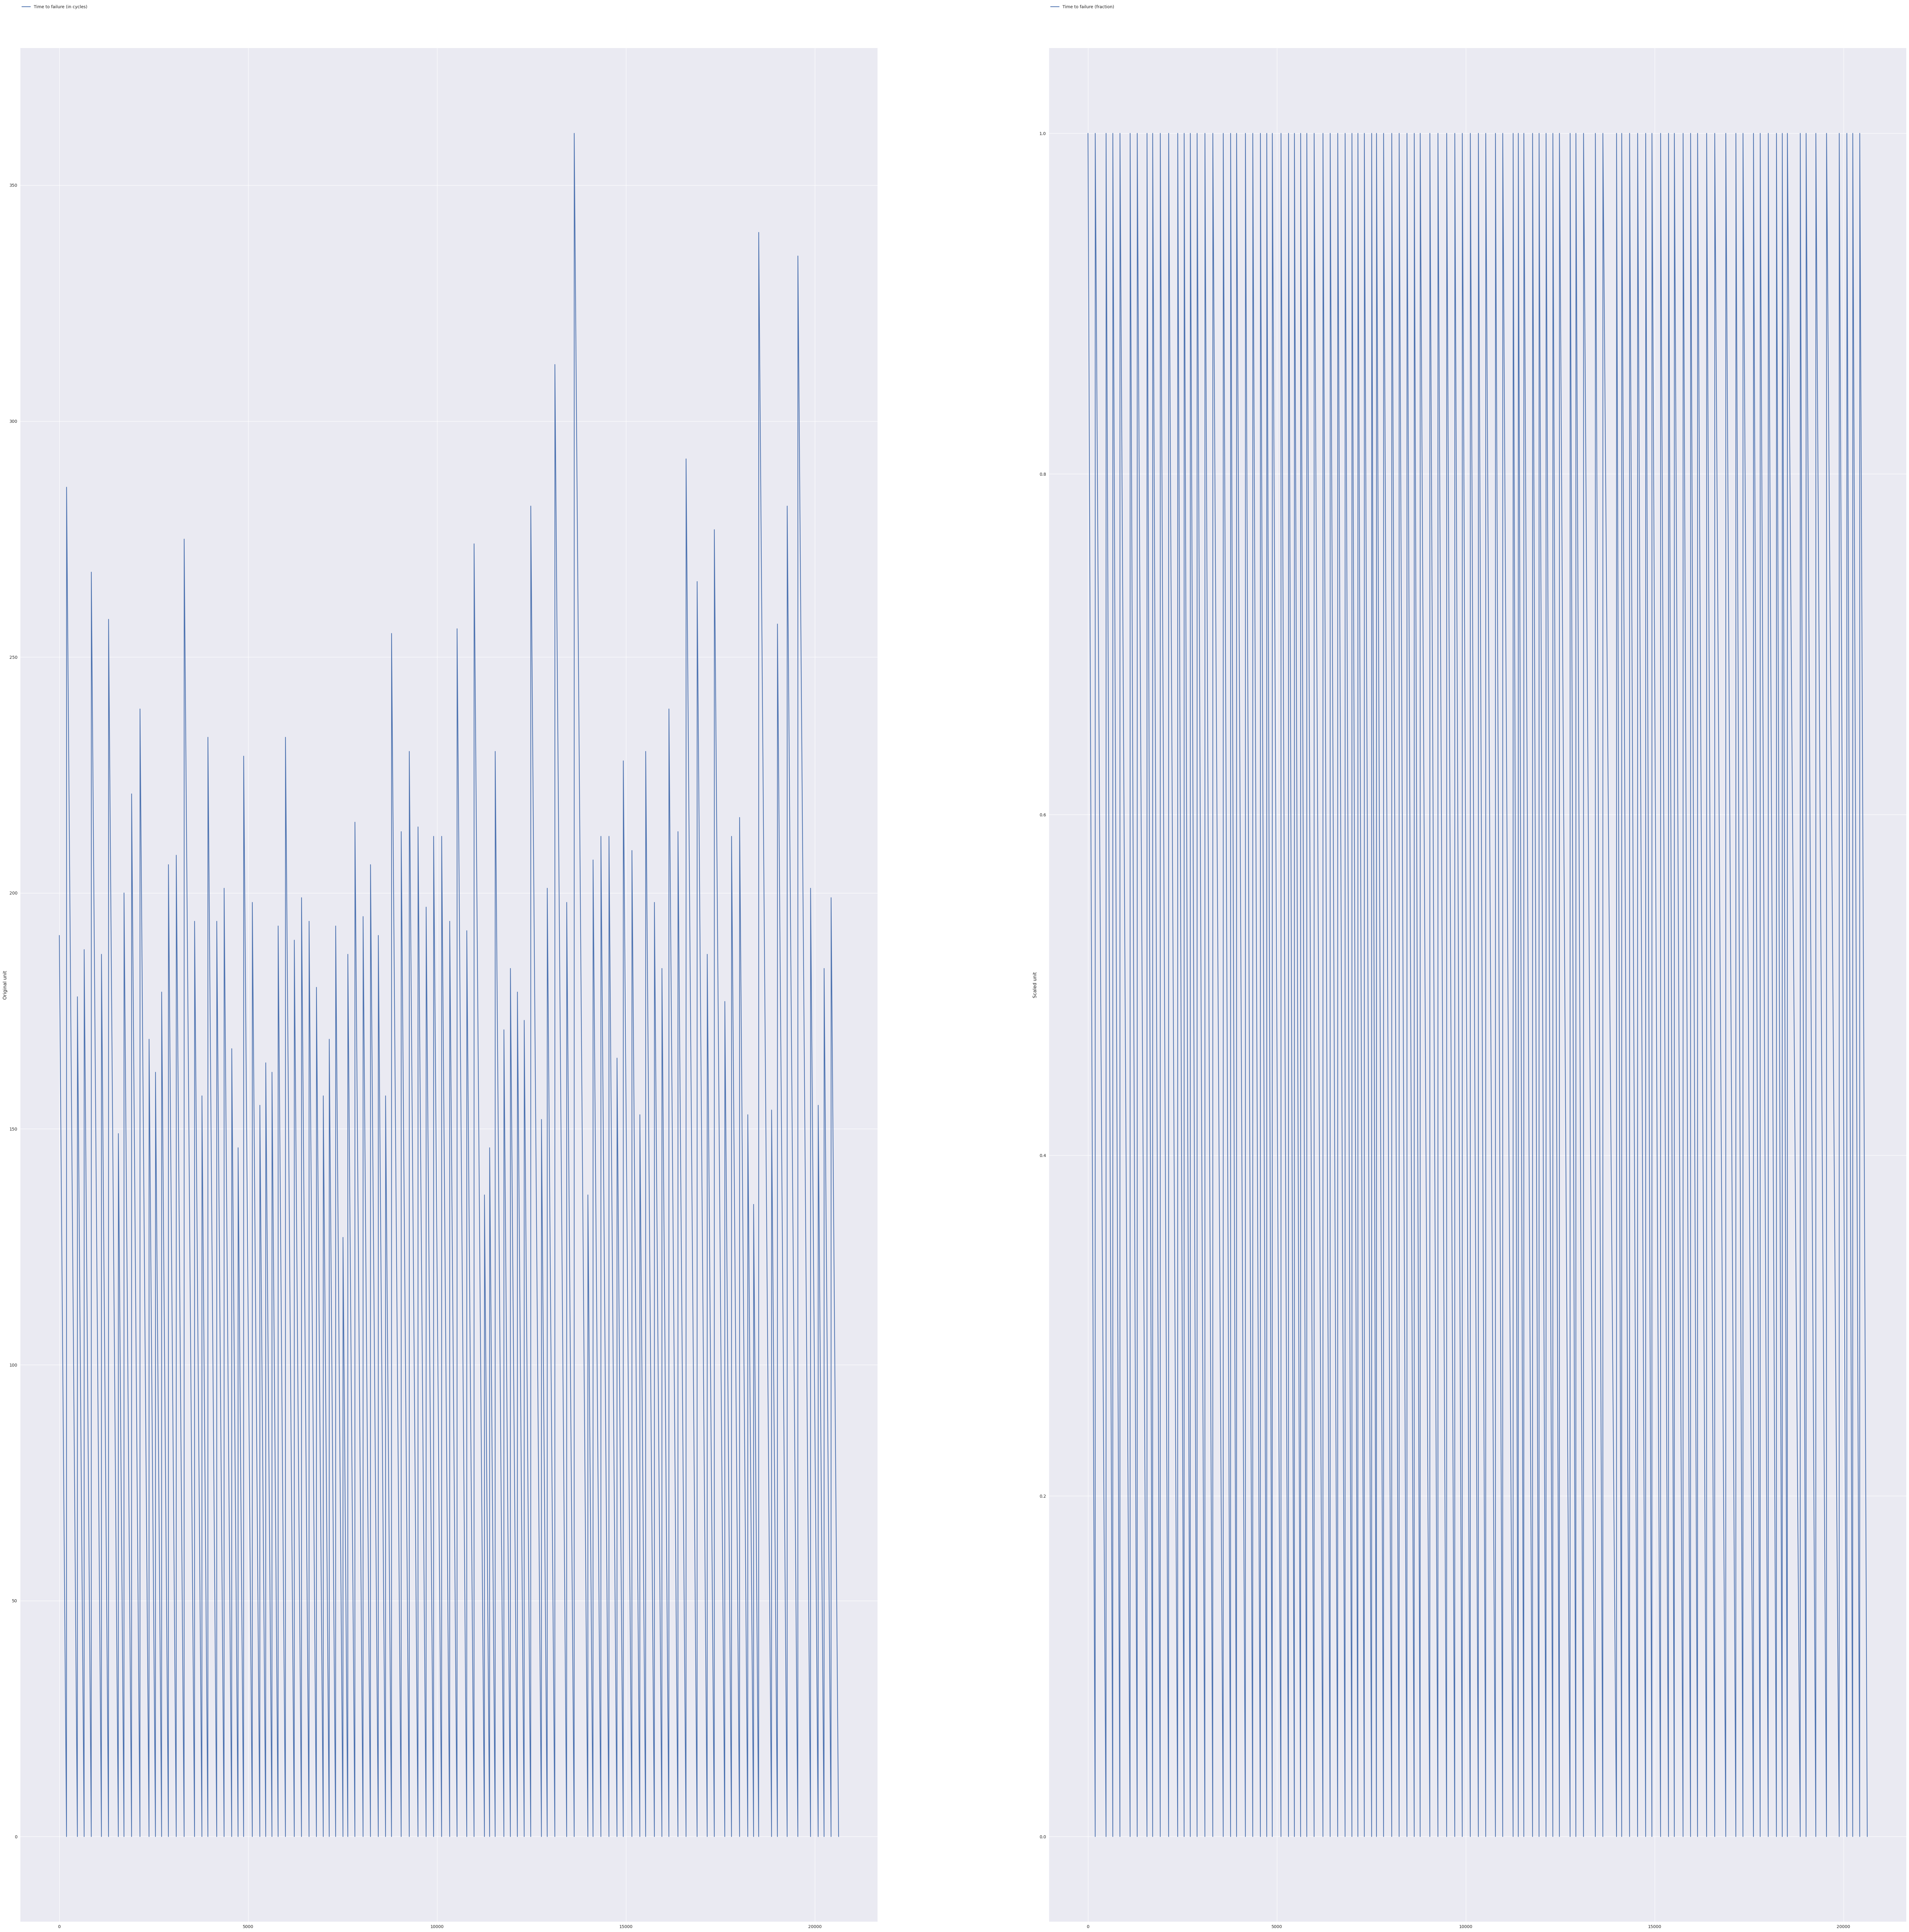

In [ ]:
def fractionTTF(dat, q):
    return (dat.RUL[q] - dat.RUL.min()) / float(dat.RUL.max() - dat.RUL.min())

fTTFz = []
fTTF = []

for i in range(train['unit_ID'].min(), train['unit_ID'].max() + 1):
    dat = train[train.unit_ID == i]
    dat = dat.reset_index(drop=True)
    for q in range(len(dat)):
        fTTFz = fractionTTF(dat, q)
        fTTF.append(fTTFz)

ntrain['fTTF'] = fTTF
mx = cyclestrain.iloc[:, 1].sum()

fig = plt.figure(figsize=(80, 80))
fig.add_subplot(1, 2, 1)
plt.plot(ntrain.RUL[0:mx])
plt.legend(['Time to failure (in cycles)'], bbox_to_anchor=(0., 1.02, 1., .102),
           loc=3, mode="expand", borderaxespad=0)
plt.ylabel('Original unit')

fig.add_subplot(1, 2, 2)
plt.plot(ntrain.fTTF[0:mx])
plt.legend(['Time to failure (fraction)'], bbox_to_anchor=(0., 1.02, 1., .102),
           loc=3, mode="expand", borderaxespad=0)
plt.ylabel('Scaled unit')

plt.show()


In [117]:
pd.DataFrame(ntrain.columns).T


0       1                                2   \
0  unit_ID  cycles  Total Temperature at LPC outlet   

                             3                             4   \
0  Total Temperature HPC outlet  Total Temperature LPT outlet   

                              5                             6   \
0  Total pressure in bypass-duct  Total pressure at HPC outlet   

                   7                    8                              9   \
0  Physcial fan speed  Physical Core speed  Static pressure at HPC outlet   

                           10                   11                    12  \
0  Ratio of fuel flow to Ps30  Corrected fan speed  Corrected core speed   

             13              14                 15                 16   17  \
0  Bypass Ratio  Bleed Enthalpy  HPT coolant bleed  LPT coolant bleed  RUL   

     18  
0  fTTF

In [127]:
X_train = ntrain.values[:,1:16]
X_train

array([[1.00000000e+00, 1.83734940e-01, 4.06801831e-01, ...,
        3.63986149e-01, 3.33333333e-01, 7.13178295e-01],
       [2.00000000e+00, 2.83132530e-01, 4.53019403e-01, ...,
        4.11312043e-01, 3.33333333e-01, 6.66666667e-01],
       [3.00000000e+00, 3.43373494e-01, 3.69522564e-01, ...,
        3.57445171e-01, 1.66666667e-01, 6.27906977e-01],
       ...,
       [1.98000000e+02, 6.65662651e-01, 6.84979289e-01, ...,
        9.22277799e-01, 8.33333333e-01, 2.32558140e-01],
       [1.99000000e+02, 6.08433735e-01, 7.46021365e-01, ...,
        8.23393613e-01, 5.83333333e-01, 1.16279070e-01],
       [2.00000000e+02, 7.95180723e-01, 6.39633748e-01, ...,
        6.87572143e-01, 6.66666667e-01, 1.78294574e-01]])

In [128]:
X_train.shape

(20631, 15)

In [129]:
Y_train = ntrain.values[:,18]
Y_train

array([1.        , 0.9947644 , 0.9895288 , ..., 0.01005025, 0.00502513,
       0.        ])

In [130]:
X_test = ntest.values[:,1:16]
X_test

array([[1.00000000e+00, 5.45180723e-01, 3.10660562e-01, ...,
        3.08964987e-01, 3.33333333e-01, 5.58139535e-01],
       [2.00000000e+00, 1.50602410e-01, 3.79550905e-01, ...,
        2.13158907e-01, 4.16666667e-01, 6.82170543e-01],
       [3.00000000e+00, 3.76506024e-01, 3.46631785e-01, ...,
        4.58637938e-01, 4.16666667e-01, 7.28682171e-01],
       ...,
       [1.96000000e+02, 6.71686747e-01, 4.82014388e-01, ...,
        5.07887649e-01, 5.83333333e-01, 3.72093023e-01],
       [1.97000000e+02, 6.17469880e-01, 5.22127752e-01, ...,
        5.62524048e-01, 5.83333333e-01, 4.03100775e-01],
       [1.98000000e+02, 5.24096386e-01, 6.66666667e-01, ...,
        6.36398615e-01, 6.66666667e-01, 4.34108527e-01]])

**Modelling**

In [131]:
regressor = RandomForestRegressor()
regressor.fit(X_train,Y_train)

RandomForestRegressor()

In [132]:
score = regressor.predict(X_test)

In [133]:
score[0:10]

array([1.        , 0.99553022, 0.99002997, 0.98576625, 0.98057215,
       0.97331621, 0.96753328, 0.96479254, 0.95689955, 0.95598374])

In [134]:
print(score.min(), score.max())

0.017903185348814632 1.0


In [137]:
test = ntest

In [140]:
test=pd.merge(test, test.groupby('unit_ID',as_index=False)['cycles'].max(), how='left', on='unit_ID')
test.rename(columns={"cycles_x": "cycles", "cycles_y": "maxcycles"}, inplace=True)
test['score'] = score
test.head()

unit_ID  cycles  Total Temperature at LPC outlet  \
0        1       1                         0.545181   
1        1       2                         0.150602   
2        1       3                         0.376506   
3        1       4                         0.370482   
4        1       5                         0.391566   

   Total Temperature HPC outlet  Total Temperature LPT outlet  \
0                      0.310661                      0.269413   
1                      0.379551                      0.222316   
2                      0.346632                      0.322248   
3                      0.285154                      0.408001   
4                      0.352082                      0.332039   

   Total pressure in bypass-duct  Total pressure at HPC outlet  \
0                            1.0                      0.652174   
1                            1.0                      0.805153   
2                            1.0                      0.685990   
3                            1.0                      0.679549   
4                            1.0                      0.694042   

   Physcial fan speed  Physical Core speed  Static pressure at HPC outlet  \
0            0.212121             0.127614                       0.208333   
1            0.166667             0.146684                       0.386905   
2            0.227273             0.158081                       0.386905   
3            0.196970             0.105717                       0.255952   
4            0.166667             0.102396                       0.273810   

   Ratio of fuel flow to Ps30  Corrected fan speed  Corrected core speed  \
0                    0.646055             0.220588              0.132160   
1                    0.739872             0.264706              0.204768   
2                    0.699360             0.220588              0.155640   
3                    0.573561             0.250000              0.170090   
4                    0.737740             0.220588              0.152751   

   Bypass Ratio  Bleed Enthalpy  HPT coolant bleed  LPT coolant bleed  \
0      0.308965        0.333333           0.558140           0.661834   
1      0.213159        0.416667           0.682171           0.686827   
2      0.458638        0.416667           0.728682           0.721348   
3      0.257022        0.250000           0.666667           0.662110   
4      0.300885        0.166667           0.658915           0.716377   

   maxcycles     score  
0         31  1.000000  
1         31  0.995530  
2         31  0.990030  
3         31  0.985766  
4         31  0.980572

In [142]:
def totcycles(data):
 return(data['cycles'] / (1-data['score']))

test['maxpredcycles'] = totcycles(test)

In [156]:
def RULfunction(data):
    return(data['maxpredcycles'] - data['maxcycles'])
test['RUL'] = RULfunction(test)
test

unit_ID  cycles  Total Temperature at LPC outlet  \
0            1       1                         0.545181   
1            1       2                         0.150602   
2            1       3                         0.376506   
3            1       4                         0.370482   
4            1       5                         0.391566   
...        ...     ...                              ...   
13091      100     194                         0.611446   
13092      100     195                         0.605422   
13093      100     196                         0.671687   
13094      100     197                         0.617470   
13095      100     198                         0.524096   

       Total Temperature HPC outlet  Total Temperature LPT outlet  \
0                          0.310661                      0.269413   
1                          0.379551                      0.222316   
2                          0.346632                      0.322248   
3                          0.285154                      0.408001   
4                          0.352082                      0.332039   
...                             ...                           ...   
13091                      0.619359                      0.566172   
13092                      0.537388                      0.671843   
13093                      0.482014                      0.414754   
13094                      0.522128                      0.626435   
13095                      0.666667                      0.721472   

       Total pressure in bypass-duct  Total pressure at HPC outlet  \
0                                1.0                      0.652174   
1                                1.0                      0.805153   
2                                1.0                      0.685990   
3                                1.0                      0.679549   
4                                1.0                      0.694042   
...                              ...                           ...   
13091                            1.0                      0.573269   
13092                            1.0                      0.542673   
13093                            1.0                      0.513688   
13094                            1.0                      0.566828   
13095                            1.0                      0.423510   

       Physcial fan speed  Physical Core speed  Static pressure at HPC outlet  \
0                0.212121             0.127614                       0.208333   
1                0.166667             0.146684                       0.386905   
2                0.227273             0.158081                       0.386905   
3                0.196970             0.105717                       0.255952   
4                0.166667             0.102396                       0.273810   
...                   ...                  ...                            ...   
13091            0.181818             0.541326                       0.500000   
13092            0.227273             0.533743                       0.446429   
13093            0.318182             0.561249                       0.428571   
13094            0.257576             0.570403                       0.452381   
13095            0.242424             0.598133                       0.565476   

       ...  Corrected fan speed  Corrected core speed  Bypass Ratio  \
0      ...             0.220588              0.132160      0.308965   
1      ...             0.264706              0.204768      0.213159   
2      ...             0.220588              0.155640      0.458638   
3      ...             0.250000              0.170090      0.257022   
4      ...             0.220588              0.152751      0.300885   
...    ...                  ...                   ...           ...   
13091  ...             0.176471              0.584890      0.564063   
13092  ...             0.308824              0.572350      0.485956   
13093  ...      

In [157]:
test['RUL'].head()

0           inf
1    416.449362
2    269.901728
3    250.022231
4    226.362477
Name: RUL, dtype: float64

In [159]:
t = test.columns == 'RUL'
ind = [i for i, x in enumerate(t) if x]

predictedRUL = []
for i in range(test.unit_ID.min(), test.unit_ID.max()+1):
    npredictedRUL = test[test.unit_ID == i].iloc[test[test.unit_ID == i].cycles.max()-1, ind]
    predictedRUL.append(npredictedRUL)


In [178]:
# Create a list of true RUL values
xtrueRUL = list(data_RUL[0])

# Initialize an empty list for the true RUL values
otrueRUL = []

# Iterate over the true RUL values
for i in range(0, len(xtrueRUL)):
    # Generate a list of decreasing integers from the current RUL value down to 0
    otrueRUL = np.concatenate((otrueRUL, list(reversed(np.arange(int(xtrueRUL[i]))))))

# Round the predicted RUL values to the nearest integer
xpredictedRUL = list(round(x) for x in predictedRUL)

# Initialize an empty list for the predicted RUL values
opredictedRUL = []

# Iterate over the predicted RUL values
for i in range(0, len(xpredictedRUL)):
    # Generate a list of decreasing integers from the predicted RUL value down to 0
    opredictedRUL = np.concatenate((opredictedRUL, list(reversed(np.arange(xpredictedRUL[i].item())))))

# Convert the predicted RUL values to integers
xpredictedRUL1 = []
for i in range(0, len(xpredictedRUL)):
    xpredictedRUL1.append(int(xpredictedRUL[i]))

# Convert the predicted RUL values to a numpy array
xpredictedRUL2 = np.array(xpredictedRUL1)


In [179]:
print(otrueRUL)

[111. 110. 109. ...   2.   1.   0.]


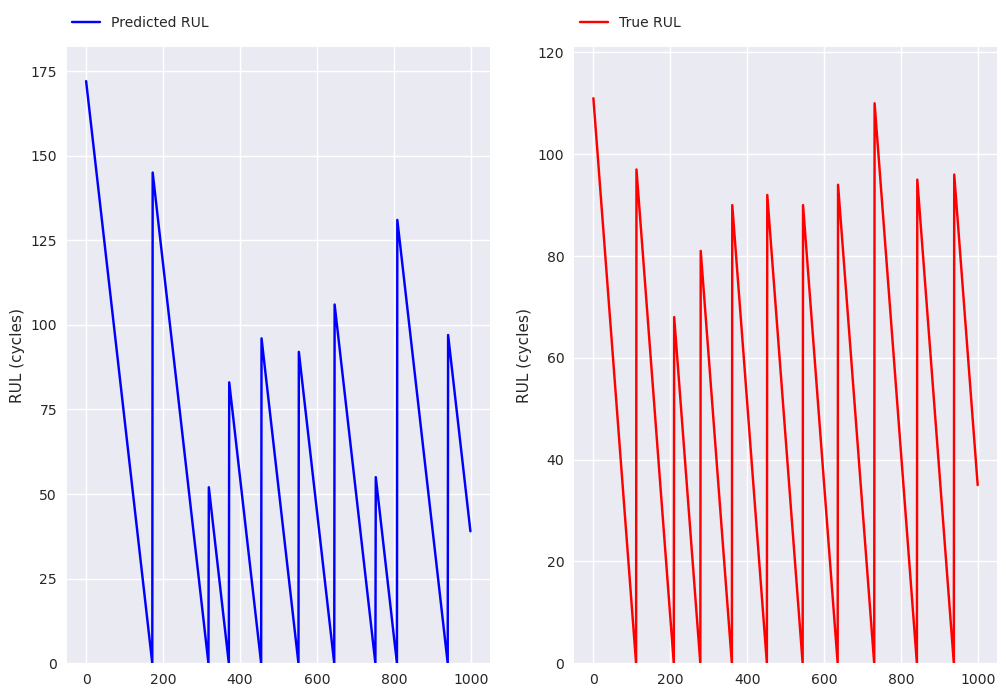

In [181]:
mx = 1000

fig = plt.figure(figsize=(12, 8))

fig.add_subplot(1, 2, 1)
plt.plot(opredictedRUL[0:mx], color='blue')
plt.legend(['Predicted RUL'], bbox_to_anchor=(0., 1.02, 1., .102),
           loc=3, mode='expand', borderaxespad=0)
plt.ylim(0, opredictedRUL[0:mx].max() + 10)
plt.ylabel('RUL (cycles)')

fig.add_subplot(1, 2, 2)
plt.plot(otrueRUL[0:mx], color='red')
plt.legend(['True RUL'], bbox_to_anchor=(0., 1.02, 1., .102),
           loc=3, mode='expand', borderaxespad=0)
plt.ylabel('RUL (cycles)')
plt.ylim(0, otrueRUL[0:mx].max() + 10)

plt.show()



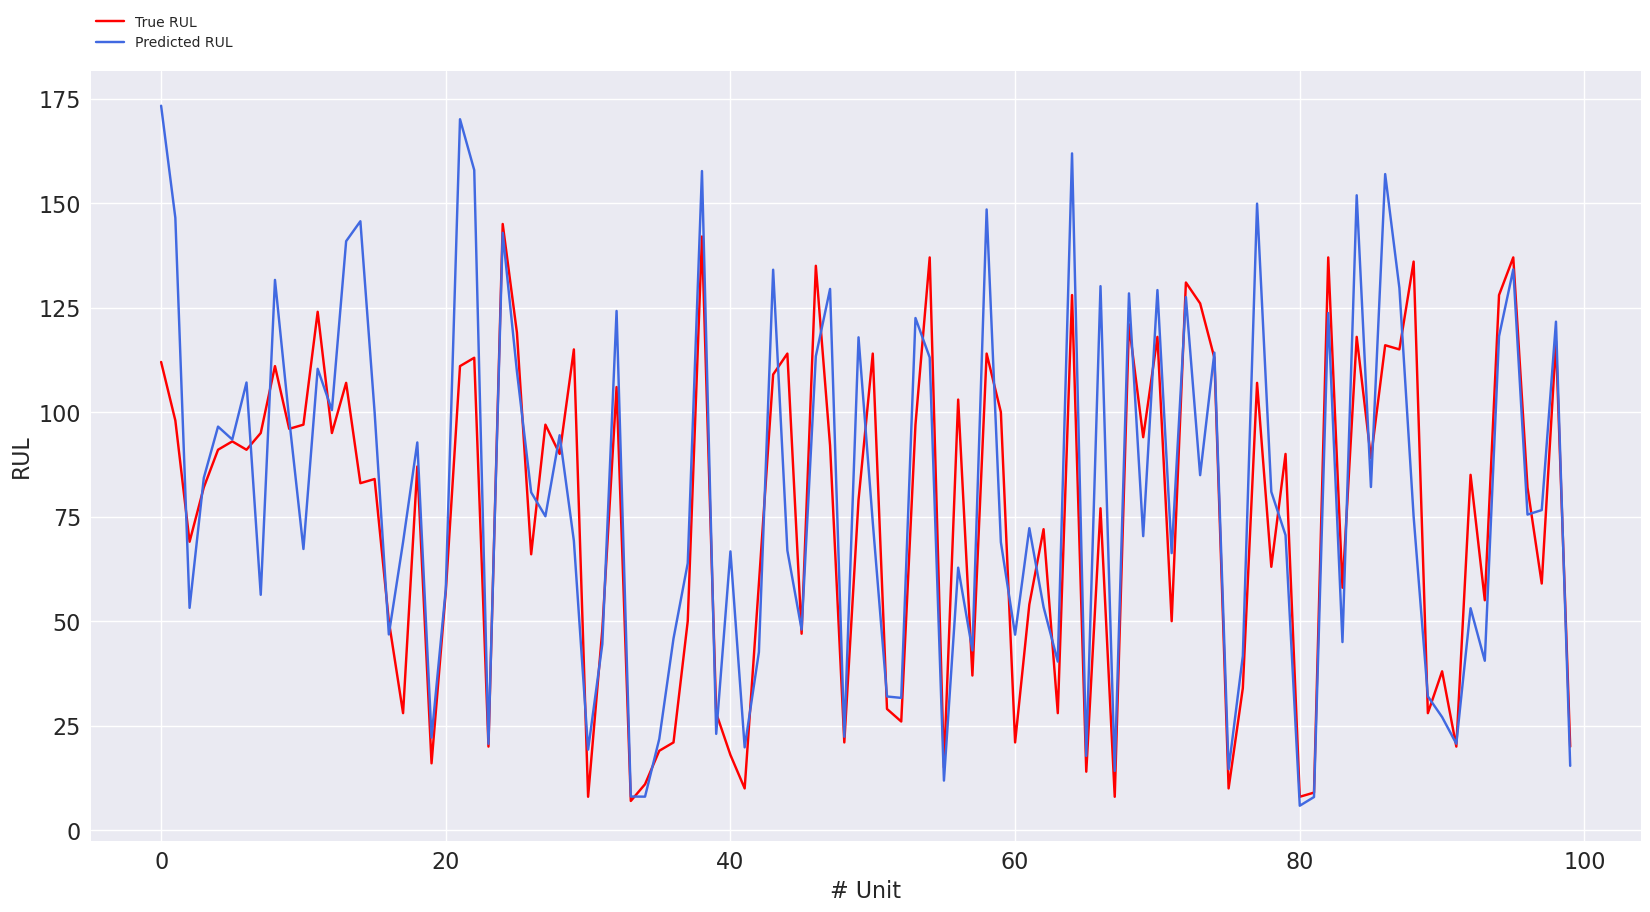

In [190]:
plt.figure(figsize=(20, 10))
plt.plot(data_RUL, color='red')
plt.plot(predictedRUL, color='royalblue')
plt.xlabel('# Unit', fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('RUL', fontsize=16)
plt.yticks(fontsize=16)
plt.legend(['True RUL', 'Predicted RUL'], bbox_to_anchor=(0., 1.02, 1., .102),
           loc=3, mode='expand', borderaxespad=0)
plt.show()
